<a href="https://colab.research.google.com/github/kavyajeetbora/CityHealthMonitor/blob/master/development/built-up-index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install and import external packages

In [1]:
!pip install -q rioxarray
!pip install -q h3
!pip install -q pydeck

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 736.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 20.1 MB/s eta 0:00:00


In [2]:
import geemap
import ee
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
import rioxarray
from shapely.geometry import Polygon, Point
import h3
from matplotlib import colormaps
import pydeck as pdk
import json
from tqdm import tqdm

ee.Authenticate()
ee.Initialize(project='kavyajeetbora-ee')

## Download the Data

- area of interest
- World Population Estimate dataset from google earth engine

In [3]:
!wget https://github.com/kavyajeetbora/modern_geospatial_stack/raw/master/notebooks/gurgaon.gpkg -O gurgaon.gpkg

--2024-05-13 12:05:13--  https://github.com/kavyajeetbora/modern_geospatial_stack/raw/master/notebooks/gurgaon.gpkg
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kavyajeetbora/modern_geospatial_stack/master/notebooks/gurgaon.gpkg [following]
--2024-05-13 12:05:13--  https://raw.githubusercontent.com/kavyajeetbora/modern_geospatial_stack/master/notebooks/gurgaon.gpkg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98304 (96K) [application/octet-stream]
Saving to: ‘gurgaon.gpkg’

gurgaon.gpkg        100%[===================>]  96.00K  --.-KB/s    in 0.01s   

2024-05-13 12:05:14 (6.32 MB/s) - ‘g

In [4]:
gurgaon_gdf = gpd.read_file('gurgaon.gpkg', crs='EPSG:4326')
geojson = gurgaon_gdf.to_json()

## Convert the geopackage file to ee.Geometry
featureCollection = ee.FeatureCollection(json.loads(geojson))
geometry = featureCollection.geometry()

## world population data

[how world population is estimated](https://www.worldpop.org/methods/top_down_constrained_vs_unconstrained/)

In [94]:
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)


dataset = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate('2020-01-01', '2020-01-30')
    # Pre-filter to get less cloudy granules.
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .map(mask_s2_clouds)
)

visualization = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

center = (gurgaon_gdf.centroid[0].y, gurgaon_gdf.centroid[0].x)
Map = geemap.Map(center=center, zoom=10)
Map.add_layer(dataset.mean(), visualization, 'RGB')
Map

Map(center=[28.437398083125167, 77.06463665845695], controls=(WidgetControl(options=['position', 'transparent_…

In [7]:
center = (gurgaon_gdf.centroid[0].y, gurgaon_gdf.centroid[0].x)
Map = geemap.Map(center=center, zoom=10)
boundary_viz_params = {
    'color':'red',
    "width":2,
    "lineType":"solid",
    'fillColorOpacity': 0.1
}
Map.addLayer(ee_object=geometry, vis_params=boundary_viz_params, name='Gurgaon Boundary')
viz_params = {
    'min': 0,
    'max': 50,
    'bands': ['population']
}
Map.addLayer(world_pop_image, viz_params, name='Population')
Map

<ipython-input-7-f1ac23a0b9ed>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = (gurgaon_gdf.centroid[0].y, gurgaon_gdf.centroid[0].x)


Map(center=[28.437398083125167, 77.06463665845695], controls=(WidgetControl(options=['position', 'transparent_…

In [8]:
geemap.ee_export_image(
    world_pop_image,
    filename='population.tif',
    scale=100,
    file_per_band=False,
    region=geometry,
)

Generating URL ...
Please wait ...
Data downloaded to /content/population.tif


## Polygon to cell using uber-h3

In [26]:
h3.polyfill

<bound method _API_FUNCTIONS.polyfill of <h3.api._api_template._API_FUNCTIONS object at 0x7a2a191cb430>>

{'type': 'Polygon',
 'coordinates': [[[77.09361966986519, 28.504366145819986],
   [77.1139233365766, 28.495759426247982],
   [77.11416220324377, 28.483792820656475],
   [77.10866826989833, 28.468675169802392],
   [77.10484640322325, 28.461955519447503],
   [77.10221886988413, 28.45166522687246],
   [77.11535653657974, 28.43843337909692],
   [77.11440106991098, 28.426670347150214],
   [77.11917840325484, 28.413225281214718],
   [77.11440106991098, 28.407132423671705],
   [77.11010146990151, 28.39830766386169],
   [77.09744153654029, 28.395365913934224],
   [77.08860346985415, 28.393264613994123],
   [77.07904880316643, 28.383598097750053],
   [77.07283826981941, 28.37960514906766],
   [77.0558787364487, 28.376873044926434],
   [77.04321880308748, 28.382547336357398],
   [77.02458720304641, 28.381076252915804],
   [77.00714993634132, 28.385279294321005],
   [77.00929973634608, 28.393684877314822],
   [77.0119272696852, 28.403350473753527],
   [77.01264386968676, 28.41721696335561],
   [7

In [90]:
h3_indices = h3.polyfill(eval(gurgaon_gdf.to_json())['features'][0]['geometry'], res=9, geo_json_conformant=True)
df_index = pd.DataFrame(h3_indices, columns=['h3_indices'])
h3_indices = df_index.set_index('h3_indices')
h3_indices.shape

(1038, 0)

In [91]:
# Define a layer to display on a map
layer = pdk.Layer(
    "H3HexagonLayer",
    h3_indices.reset_index(),
    pickable=True,
    stroked=True,
    filled=True,
    extruded=False,
    get_hexagon='h3_indices',
    get_fill_color=[143, 32, 45, 100],
    getLineWidth= 20,
    getLineColor = [143, 32, 45, 100]
)

boundary = pdk.Layer(
    "GeoJsonLayer",
    json.loads(gurgaon_gdf.to_json()),
    pickable=True,
    stroked=True,
    filled=False,
    extruded=False,
    get_line_color=[255, 32, 12],
    getLineWidth= 20,

)

# Set the viewport location
aoi = gurgaon_gdf['geometry'].iloc[0]
view_state = pdk.ViewState(latitude=aoi.centroid.y, longitude=aoi.centroid.x, zoom=11, bearing=0, pitch=30)

# Render
r = pdk.Deck(layers=[layer, boundary], initial_view_state=view_state, description='Legend')
r

<IPython.core.display.Javascript object>

{
  "description": "Legend",
  "initialViewState": {
    "bearing": 0,
    "latitude": 28.437398083125167,
    "longitude": 77.06463665845695,
    "pitch": 30,
    "zoom": 11
  },
  "layers": [
    {
      "@@type": "H3HexagonLayer",
      "data": [
        {
          "h3_indices": "893da11a343ffff"
        },
        {
          "h3_indices": "893da11aa57ffff"
        },
        {
          "h3_indices": "893da118157ffff"
        },
        {
          "h3_indices": "893da118cc3ffff"
        },
        {
          "h3_indices": "893da118273ffff"
        },
        {
          "h3_indices": "893da11aeabffff"
        },
        {
          "h3_indices": "893da118007ffff"
        },
        {
          "h3_indices": "893da119c37ffff"
        },
        {
          "h3_indices": "893da11840fffff"
        },
        {
          "h3_indices": "893da1189c3ffff"
        },
        {
          "h3_indices": "893da11ae2fffff"
        },
        {
          "h3_indices": "893da118b93ffff"
        },
        {
          "h3_indices": "893da11a84fffff"
        },
        {
          "h3_indices": "893da11882fffff"
        },
        {
          "h3_indices": "893da11810fffff"
        },
        {
          "h3_indices": "893da119d93ffff"
        },
        {
          "h3_indices": "893da118ccfffff"
        },
        {
          "h3_indices": "893da118d8fffff"
        },
        {
          "h3_indices": "893da11a86bffff"
        },
        {
          "h3_indices": "893da11829bffff"
        },
        {
          "h3_indices": "893da11ad57ffff"
        },
        {
          "h3_indices": "893da1182c3ffff"
        },
        {
          "h3_indices": "893da111a27ffff"
        },
        {
          "h3_indices": "893da118497ffff"
        },
        {
          "h3_indices": "893da118d67ffff"
        },
        {
          "h3_indices": "893da118013ffff"
        },
        {
          "h3_indices": "893da11ad1bffff"
        },
        {
          "h3_indices": "893da119da3ffff"
        },
        {
          "h3_indices": "893da119d13ffff"
        },
        {
          "h3_indices": "893da11a347ffff"
        },
        {
          "h3_indices": "893da11ae5bffff"
        },
        {
          "h3_indices": "893da118283ffff"
        },
        {
          "h3_indices": "893da111e4bffff"
        },
        {
          "h3_indices": "893da11a8d7ffff"
        },
        {
          "h3_indices": "893da111bcfffff"
        },
        {
          "h3_indices": "893da1188a7ffff"
        },
        {
          "h3_indices": "893da118d6bffff"
        },
        {
          "h3_indices": "893da111aa7ffff"
        },
        {
          "h3_indices": "893da11843bffff"
        },
        {
          "h3_indices": "893da11a9afffff"
        },
        {
          "h3_indices": "893da111a63ffff"
        },
        {
          "h3_indices": "893da11ab7bffff"
        },
        {
          "h3_indices": "893da11aba3ffff"
        },
        {
          "h3_indices": "893da1180cfffff"
        },
        {
          "h3_indices": "893da118c03ffff"
        },
        {
          "h3_indices": "893da11a943ffff"
        },
        {
          "h3_indices": "893da118567ffff"
        },
        {
          "h3_indices": "893da118863ffff"
        },
        {
          "h3_indices": "893da11aeb3ffff"
        },
        {
          "h3_indices": "893da11aac7ffff"
        },
        {
          "h3_indices": "893da118473ffff"
        },
        {
          "h3_indices": "893da11813bffff"
        },
        {
          "h3_indices": "893da111ac3ffff"
        },
        {
          "h3_indices": "893da11adc3ffff"
        },
        {
          "h3_indices": "893da1181c3ffff"
        },
        {
          "h3_indices": "893da11ae0fffff"
        },
        {
          "h3_indices": "893da11ac43ffff"
        },
        {
          "h3_indices": "893da11aa23ffff"
        },
        {
          "h3_indices": "893da118c8fffff"
        },
        {
          "h3_indices":

## Converting the raster to xyz point data


In [9]:
def raster_to_xyz(raster_file, val_col):
    xds = rioxarray.open_rasterio('population.tif')\
            .sel(band=1)\
            .to_pandas()

    xds = xds.stack().reset_index().rename(columns={"x": 'lng', 'y': 'lat', 0: val_col})
    return xds

def convert_to_gdf(df, aoi):
    df['geometry'] = list(map(Point, zip(df['lng'], df['lat'])))
    gdf = gpd.GeoDataFrame(df, crs='EPSG:4326', geometry='geometry')

    ## Clip the geometry
    gdf = gdf[gdf['geometry'].within(aoi)]
    print(f"Total of {gdf.shape[0]} points are in the dataset")

    return gdf


def aggregate_gdf_by_h3(gdf, APERTURE_SIZE, agg='sum', val_col='population'):
    hex_col = 'hex'+str(APERTURE_SIZE)

    # find hex indices for all the points
    gdf[hex_col] = gdf.apply(lambda x: h3.geo_to_h3(x.lat,x.lng,APERTURE_SIZE),1)

    # calculate temperature average per hex
    hex_data = gdf.groupby(hex_col)[val_col].agg(agg).to_frame(val_col).reset_index()

    return hex_data

1. Convert raster to xyz points

In [10]:
xds = raster_to_xyz('population.tif', val_col='population', )
xds = xds[xds['population']>0]
print(xds.shape)
print(xds['population'].min(), xds['population'].max())
xds.head()

(19364, 3)
5.0605803 112.68387


,lat,lng,population
0,28.510111,77.003728,18.283073
1,28.510111,77.004627,29.219259
2,28.510111,77.005525,32.136192
3,28.510111,77.006423,33.248539
4,28.510111,77.007322,32.943436


2. Convert the points to GeoDataFrame

In [11]:
aoi = gurgaon_gdf['geometry'].iloc[0]
gdf = convert_to_gdf(xds, aoi)
gdf.sample(5)

Total of 12923 points are in the dataset


,lat,lng,population,geometry
14617,28.409500,77.054932,38.825340,POINT (77.05493 28.40950)
4229,28.481365,77.065712,76.269814,POINT (77.06571 28.48137)
10627,28.437348,77.090865,33.345390,POINT (77.09086 28.43735)
9508,28.444534,77.019898,75.340569,POINT (77.01990 28.44453)
10334,28.439144,77.061221,80.182304,POINT (77.06122 28.43914)


3. Aggregate all the values by h3 indices

In [12]:
APERTURE_SIZE=8
pop_hex_data = aggregate_gdf_by_h3(gdf, APERTURE_SIZE=APERTURE_SIZE, agg='sum', val_col='population')
pop_hex_data.sample(3)

,hex8,population
129,883da11a85fffff,7136.251953
105,883da118e7fffff,2120.169434
109,883da1195bfffff,818.026855


After creating the hexagons using the h3 spatial index, the point data are reduced to 3545 from 299484.This saves a significant amount of disk space.

Also compared to geometries which are mostly having coordinates with float numbers, it is more efficient to store a h3 index as it is a string object with fixed number of characters (15-16 characters)

To view the h3 spatial indices, check out this [Uber h3 viewer](https://wolf-h3-viewer.glitch.me/)

## Visualizing the results in pydeck

for visualizing the surface temperature data, we will first format the data


- Normalizing the temperature values
- then color coding the temperature values using a colormap
- splitting the colormap values to make it compatible with pydeck `get_fill_color` attribute
- Formatting a tooltip for interactive data visualization

In [13]:
def color_code_value(value, cmap):
    color = cmap(value)
    scaled_colors = list(map(lambda x: int(x*255), color[:3]))
    scaled_alpha = int(color[3]*100)

    scaled_colors += [scaled_alpha]
    return scaled_colors

def colormap_dataframe(df, value_col, cmap):

    xdf = df.copy()

    ## Scale the temperature values between 0-1; using MinMax Scaler
    xdf[f'norm_{value_col}'] = (xdf[value_col]-xdf[value_col].min())/(xdf[value_col].max()-xdf[value_col].min())
    xdf['color'] = xdf[f'norm_{value_col}'].apply(lambda x: color_code_value(x, cmap))
    xdf[['R', 'G', 'B', 'A']] = pd.DataFrame(xdf['color'].to_list())
    xdf = xdf.drop(['color', f'norm_{value_col}'], axis=1)

    ## formatting the temperature value upto 1 decimal place
    xdf[value_col] = xdf[value_col].astype(int)

    return xdf

def create_h3_hex_layer(df,hex_col):

    # Define a layer to display on a map
    layer = pdk.Layer(
        "H3HexagonLayer",
        df,
        pickable=True,
        stroked=True,
        filled=True,
        extruded=False,
        get_hexagon=hex_col,
        get_fill_color="[R, G, B, A]"
    )

    return layer

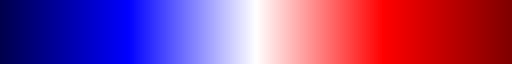

In [14]:
## Choose a colormap
cmap = colormaps['seismic']
cmap

Generating the tooltip:

In [15]:
tooltip = {
        "html": "<b>Population</b>: {population}",
        "style": {
            "backgroundColor": "#4CAF50",   # Green shade for background
            "color": "#FFFFFF",             # White for text color
            "border": "2px solid #4CAF50",  # Matching border color
            "borderRadius": "5px",          # Rounded corners
            "boxShadow": "2px 2px 10px rgba(0, 0, 0, 0.2)"  # Soft shadow effect
        }
    }

## Finally plotting the results on a 3D map

In [16]:
## Apply the colormap to the dataframe
value_col='population'

xdf = colormap_dataframe(df=pop_hex_data, value_col=value_col, cmap=cmap)

## Now create a H3HexagonLayer
hex_col = f'hex{APERTURE_SIZE}'
layer = create_h3_hex_layer(xdf, hex_col)

# Set the viewport location
view_state = pdk.ViewState(latitude=aoi.centroid.y, longitude=aoi.centroid.x, zoom=11, bearing=0, pitch=30)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip=tooltip, description='Legend')
r

<IPython.core.display.Javascript object>

{
  "description": "Legend",
  "initialViewState": {
    "bearing": 0,
    "latitude": 28.437398083125167,
    "longitude": 77.06463665845695,
    "pitch": 30,
    "zoom": 11
  },
  "layers": [
    {
      "@@type": "H3HexagonLayer",
      "data": [
        {
          "A": 100,
          "B": 255,
          "G": 45,
          "R": 45,
          "hex8": "883da10341fffff",
          "population": 2284
        },
        {
          "A": 100,
          "B": 177,
          "G": 177,
          "R": 255,
          "hex8": "883da10345fffff",
          "population": 4454
        },
        {
          "A": 100,
          "B": 61,
          "G": 61,
          "R": 255,
          "hex8": "883da10349fffff",
          "population": 5307
        },
        {
          "A": 100,
          "B": 171,
          "G": 0,
          "R": 0,
          "hex8": "883da1034bfffff",
          "population": 1056
        },
        {
          "A": 100,
          "B": 221,
          "G": 221,
          "R": 255,
          "hex8": "883da1034dfffff",
          "population": 4121
        },
        {
          "A": 100,
          "B": 112,
          "G": 0,
          "R": 0,
          "hex8": "883da10361fffff",
          "population": 419
        },
        {
          "A": 100,
          "B": 255,
          "G": 61,
          "R": 61,
          "hex8": "883da10365fffff",
          "population": 2410
        },
        {
          "A": 100,
          "B": 213,
          "G": 213,
          "R": 255,
          "hex8": "883da10369fffff",
          "population": 4167
        },
        {
          "A": 100,
          "B": 84,
          "G": 0,
          "R": 0,
          "hex8": "883da1036bfffff",
          "population": 113
        },
        {
          "A": 100,
          "B": 157,
          "G": 157,
          "R": 255,
          "hex8": "883da1036dfffff",
          "population": 4598
        },
        {
          "A": 100,
          "B": 118,
          "G": 0,
          "R": 0,
          "hex8": "883da11137fffff",
          "population": 495
        },
        {
          "A": 100,
          "B": 236,
          "G": 0,
          "R": 0,
          "hex8": "883da11185fffff",
          "population": 1743
        },
        {
          "A": 100,
          "B": 0,
          "G": 0,
          "R": 231,
          "hex8": "883da111a1fffff",
          "population": 6112
        },
        {
          "A": 100,
          "B": 0,
          "G": 0,
          "R": 205,
          "hex8": "883da111a3fffff",
          "population": 6501
        },
        {
          "A": 100,
          "B": 0,
          "G": 0,
          "R": 193,
          "hex8": "883da111a5fffff",
          "population": 6706
        },
        {
          "A": 100,
          "B": 0,
          "G": 0,
          "R": 223,
          "hex8": "883da111a7fffff",
          "population": 6258
        },
        {
          "A": 100,
          "B": 5,
          "G": 5,
          "R": 255,
          "hex8": "883da111a9fffff",
          "population": 5725
        },
        {
          "A": 100,
          "B": 153,
          "G": 153,
          "R": 255,
          "hex8": "883da111abfffff",
          "population": 4637
        },
        {
          "A": 100,
          "B": 0,
          "G": 0,
          "R": 167,
          "hex8": "883da111adfffff",
          "population": 7077
        },
        {
          "A": 100,
          "B": 255,
          "G": 193,
          "R": 193,
          "hex8": "883da111b5fffff",
          "population": 3407
        },
        {
          "A": 100,
          "B": 244,
          "G": 0,
          "R": 0,
          "hex8": "883da111bdfffff",
          "population": 1841
        },
        {
          "A": 100,
          "B": 255,
          "G": 145,
          "R": 145,
          "hex8": "883da111e1fffff",
          "population": 3034
        },
        {
          "A": 100,
          "B": 255,
          "G": 104,
          "R": 104,
          "hex8": "883da111e3fffff",
       

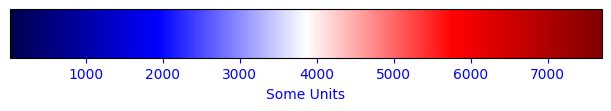

In [17]:
import matplotlib as mpl
COLOR = 'blue'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')
norm = mpl.colors.Normalize(vmin=xdf['population'].min(), vmax=xdf['population'].max())
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Some Units')
fig.savefig('temp.png', transparent=True)

## WorldPop Global Project Population Data: Estimated Age and Sex Structures of Residential Population per 100x100m Grid Square

In [18]:
world_pop_age_sex = ee.ImageCollection("WorldPop/GP/100m/pop_age_sex")\
.filter(ee.Filter.eq('country','IND'))\
.filter(ee.Filter.eq('year', 2020))\
.first().clip(geometry)

geemap.ee_export_image(
    world_pop_age_sex,
    filename='pop_age_sex.tif',
    scale=100,
    file_per_band=False,
    region=geometry,
)

Generating URL ...
Please wait ...
Data downloaded to /content/pop_age_sex.tif


In [19]:
bandNames = world_pop_age_sex.bandNames().getInfo()
len(bandNames)

37

In [20]:
# band_as_variable
xr = rioxarray.open_rasterio('pop_age_sex.tif')
final_df = None
for i, band in enumerate(bandNames):
    pas_df = xr.sel(band=i+1).to_pandas()
    pas_df = pas_df.stack().reset_index().rename(columns={"x": 'lng', 'y': 'lat', 0: band})

    ## Join the dataset
    if i == 0:
        final_df = pas_df
    else:
        final_df = final_df.join(pas_df[[band]])

In [21]:
final_df.sample(4)

,lat,lng,population,M_0,M_1,M_5,M_10,M_15,M_20,M_25,...,F_35,F_40,F_45,F_50,F_55,F_60,F_65,F_70,F_75,F_80
5938,28.469687,77.082780,84.132317,0.845294,3.238862,3.656639,3.619586,3.892333,4.544893,4.793651,...,3.236271,2.526827,1.996661,1.815431,1.544657,1.356428,0.915477,0.617200,0.426732,0.468644
3214,28.488552,77.088170,78.960869,0.793335,3.039775,3.431873,3.397097,3.653079,4.265528,4.498995,...,3.037344,2.371508,1.873931,1.703840,1.449710,1.273051,0.859204,0.579262,0.400502,0.439837
5055,28.475975,77.107035,37.993385,0.326382,1.250577,1.587201,1.720973,1.898479,2.126555,2.092060,...,1.471316,1.243006,1.023781,0.842989,0.655680,0.517119,0.335129,0.227947,0.168674,0.164383
9207,28.447229,77.099848,61.159283,0.614479,2.354463,2.658163,2.631228,2.829499,3.303872,3.484704,...,2.352580,1.836856,1.451456,1.319713,1.122875,0.986044,0.665498,0.448668,0.310210,0.340677


In [22]:
pas_gdf = convert_to_gdf(final_df, aoi)
pas_gdf.sample(3)

Total of 12925 points are in the dataset


,lat,lng,population,M_0,M_1,M_5,M_10,M_15,M_20,M_25,...,F_40,F_45,F_50,F_55,F_60,F_65,F_70,F_75,F_80,geometry
18368,28.383449,77.037864,24.952208,0.250700,0.960591,1.084497,1.073507,1.154399,1.347938,1.421715,...,0.749414,0.592176,0.538426,0.458119,0.402293,0.271515,0.183051,0.126562,0.138992,POINT (77.03786 28.38345)
19172,28.378059,77.059424,27.430416,0.275599,1.055995,1.192207,1.180126,1.269052,1.481812,1.562917,...,0.823844,0.650989,0.591901,0.503618,0.442248,0.298481,0.201231,0.139131,0.152796,POINT (77.05942 28.37806)
8546,28.451721,77.089967,40.002666,0.401915,1.539992,1.738634,1.721016,1.850700,2.160975,2.279253,...,1.201439,0.949359,0.863189,0.734443,0.644945,0.435285,0.293462,0.202900,0.222827,POINT (77.08997 28.45172)


In [23]:
pas_hexdata = None
APERTURE_SIZE=8
for i, band in tqdm(enumerate(bandNames)):
    if i == 0:
        pas_hexdata = aggregate_gdf_by_h3(pas_gdf, APERTURE_SIZE=APERTURE_SIZE, agg='sum', val_col=band).set_index(f'hex{APERTURE_SIZE}')
    else:
        pas_hexdata2 = aggregate_gdf_by_h3(pas_gdf, APERTURE_SIZE=APERTURE_SIZE, agg='sum', val_col=band).set_index(f'hex{APERTURE_SIZE}')
        pas_hexdata = pas_hexdata.join(pas_hexdata2)

## set population equal to zero for no data
pas_hexdata[pas_hexdata<0]=0

## Set all the variables as int
pas_hexdata = pas_hexdata.astype(int)

## Reset the index
pas_hexdata = pas_hexdata.reset_index()

37it [00:10,  3.45it/s]


In [24]:
pas_hexdata.sample(3)

,hex8,population,M_0,M_1,M_5,M_10,M_15,M_20,M_25,M_30,...,F_35,F_40,F_45,F_50,F_55,F_60,F_65,F_70,F_75,F_80
134,883da11a91fffff,6855,68,263,297,294,317,370,390,385,...,263,205,162,147,125,110,74,50,34,38
118,883da119ddfffff,2472,24,95,107,106,114,133,140,138,...,95,74,58,53,45,39,26,18,12,13
103,883da118e3fffff,2624,26,101,114,112,121,141,149,147,...,100,78,62,56,48,42,28,19,13,14


### Plotting a pie chart to show sex ratio

In [ ]:
male_cols = [col for col in pas_hexdata.columns if col.startswith('M')]
female_cols = [col for col in pas_hexdata.columns if col.startswith('F')]

pas_hexdata['sum_male'] = (pas_hexdata[male_cols].sum(axis=1)/pas_hexdata['population']*100).round()
pas_hexdata['sum_female'] = 100 - pas_hexdata['sum_male']

pas_hexdata.sample(5)

,hex8,population,M_0,M_1,M_5,M_10,M_15,M_20,M_25,M_30,...,F_45,F_50,F_55,F_60,F_65,F_70,F_75,F_80,sum_male,sum_female
169,883da11ae3fffff,6652,66,256,289,286,307,359,379,373,...,157,143,122,107,72,48,33,37,54.0,46.0
59,883da1184dfffff,63,0,2,2,2,2,3,3,3,...,1,1,1,1,0,0,0,0,40.0,60.0
125,883da11a37fffff,4602,46,177,200,197,212,248,262,258,...,109,99,84,74,50,33,23,25,54.0,46.0
18,883da111adfffff,7077,71,272,307,304,327,382,403,397,...,167,152,129,114,77,51,35,39,54.0,46.0
122,883da11a31fffff,4632,46,178,201,199,214,250,263,260,...,109,99,85,74,50,33,23,25,54.0,46.0


In [ ]:
tooltip = {
        "html": '''<b>Population</b>: {population}<br>
        <b>Male</b>: {sum_male} %<br>
        <b>Female</b>: {sum_female} %
        ''',
        "style": {
            "backgroundColor": "#4CAF50",   # Green shade for background
            "color": "#FFFFFF",             # White for text color
            "border": "2px solid #4CAF50",  # Matching border color
            "borderRadius": "5px",          # Rounded corners
            "boxShadow": "2px 2px 10px rgba(0, 0, 0, 0.2)"  # Soft shadow effect
        }
    }

In [ ]:
## Apply the colormap to the dataframe
value_col='population'

xdf = colormap_dataframe(df=pas_hexdata, value_col=value_col, cmap=cmap)

## Now create a H3HexagonLayer
hex_col = f'hex{APERTURE_SIZE}'
layer = create_h3_hex_layer(xdf, hex_col)

# Set the viewport location
view_state = pdk.ViewState(latitude=aoi.centroid.y, longitude=aoi.centroid.x, zoom=11, bearing=0, pitch=30)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip=tooltip, description='Legend')
r

<IPython.core.display.Javascript object>

{
  "description": "Legend",
  "initialViewState": {
    "bearing": 0,
    "latitude": 28.437398083125167,
    "longitude": 77.06463665845695,
    "pitch": 30,
    "zoom": 11
  },
  "layers": [
    {
      "@@type": "H3HexagonLayer",
      "data": [
        {
          "A": 100,
          "B": 255,
          "F_0": 16,
          "F_1": 64,
          "F_10": 84,
          "F_15": 92,
          "F_20": 102,
          "F_25": 105,
          "F_30": 99,
          "F_35": 88,
          "F_40": 74,
          "F_45": 61,
          "F_5": 79,
          "F_50": 50,
          "F_55": 39,
          "F_60": 31,
          "F_65": 20,
          "F_70": 13,
          "F_75": 10,
          "F_80": 9,
          "G": 45,
          "M_0": 19,
          "M_1": 75,
          "M_10": 103,
          "M_15": 114,
          "M_20": 127,
          "M_25": 125,
          "M_30": 119,
          "M_35": 106,
          "M_40": 87,
          "M_45": 74,
          "M_5": 95,
          "M_50": 58,
          "M_55": 47,
          "M_60": 33,
          "M_65": 21,
          "M_70": 11,
          "M_75": 8,
          "M_80": 7,
          "R": 45,
          "hex8": "883da10341fffff",
          "population": 2284,
          "sum_female": 46.0,
          "sum_male": 54.0
        },
        {
          "A": 100,
          "B": 173,
          "F_0": 33,
          "F_1": 128,
          "F_10": 162,
          "F_15": 176,
          "F_20": 198,
          "F_25": 207,
          "F_30": 196,
          "F_35": 172,
          "F_40": 143,
          "F_45": 117,
          "F_5": 154,
          "F_50": 98,
          "F_55": 77,
          "F_60": 62,
          "F_65": 40,
          "F_70": 27,
          "F_75": 20,
          "F_80": 20,
          "G": 173,
          "M_0": 39,
          "M_1": 150,
          "M_10": 200,
          "M_15": 219,
          "M_20": 247,
          "M_25": 246,
          "M_30": 235,
          "M_35": 208,
          "M_40": 168,
          "M_45": 141,
          "M_5": 187,
          "M_50": 111,
          "M_55": 90,
          "M_60": 65,
          "M_65": 43,
          "M_70": 24,
          "M_75": 17,
          "M_80": 15,
          "R": 255,
          "hex8": "883da10345fffff",
          "population": 4454,
          "sum_female": 46.0,
          "sum_male": 54.0
        },
        {
          "A": 100,
          "B": 61,
          "F_0": 41,
          "F_1": 158,
          "F_10": 185,
          "F_15": 200,
          "F_20": 231,
          "F_25": 251,
          "F_30": 240,
          "F_35": 204,
          "F_40": 165,
          "F_45": 133,
          "F_5": 182,
          "F_50": 115,
          "F_55": 94,
          "F_60": 79,
          "F_65": 53,
          "F_70": 35,
          "F_75": 25,
          "F_80": 26,
          "G": 61,
          "M_0": 49,
          "M_1": 191,
          "M_10": 233,
          "M_15": 254,
          "M_20": 291,
          "M_25": 298,
          "M_30": 289,
          "M_35": 249,
          "M_40": 195,
          "M_45": 158,
          "M_5": 226,
          "M_50": 125,
          "M_55": 103,
          "M_60": 80,
          "M_65": 56,
          "M_70": 32,
          "M_75": 23,
          "M_80": 20,
          "R": 255,
          "hex8": "883da10349fffff",
          "population": 5307,
          "sum_female": 46.0,
          "sum_male": 54.0
        },
        {
          "A": 100,
          "B": 174,
          "F_0": 7,
          "F_1": 29,
          "F_10": 39,
          "F_15": 42,
          "F_20": 47,
          "F_25": 48,
          "F_30": 46,
          "F_35": 40,
          "F_40": 34,
          "F_45": 28,
          "F_5": 36,
          "F_50": 23,
          "F_55": 18,
          "F_60": 14,
          "F_65": 9,
          "F_70": 6,
          "F_75": 4,
          "F_80": 4,
          "G": 0,
          "M_0": 9,
          "M_1": 34,
          "M_10": 47,
          "M_15": 52,
          "M_20": 59,
          "M_25": 58,
          "M_30": 55,
          "M_35": 49,
          "M_40": 40,
          "M_45": 34,

## Reference

1. [Create a choropleth map using h3 and plotly](https://medium.com/@ransaka/how-to-create-a-choropleth-map-using-uber-h3-plotly-python-c65555744c87)

2. [Uber h3 py notebook](https://github.com/uber/h3-py-notebooks/blob/master/notebooks/unified_data_layers.ipynb)

3. [All available matplotlib colormaps for plotting](https://matplotlib.org/stable/users/explain/colors/colormaps.html)

4. [WorldPop Global Project Population Data: Estimated Residential Population per 100x100m Grid Square](https://developers.google.com/earth-engine/datasets/catalog/WorldPop_GP_100m_pop#description)

5. [Adding a legend to pydeck maps](https://github.com/visgl/deck.gl/issues/4850)

## VIIRS Nighttime Data

Resolution = 463.83 meters, radiance values are in Nano Watts/sr/$cm^2$

**Understanding VIIRS DNB Data:**
1. The VIIRS DNB captures radiance values in the visible and near-infrared spectrum during both day and night.
2. These radiance values represent the amount of light detected by the sensor at nighttime.
3. Higher radiance values indicate brighter sources of light (e.g., urban areas, artificial lighting).
4. Lower radiance values correspond to darker regions with less light.

**Business Decision-Making:**
1. Identify potential retail locations based on radiance patterns.
2. Consider areas with moderate to high radiance (indicating activity) and proximity to potential customers.
3. Avoid areas with extremely low radiance (e.g., remote rural regions).

In [ ]:
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/ANNUAL_V22")\
.filter(ee.Filter.date('2022-01-01', '2023-01-01'))\
.filter(ee.Filter.bounds(geometry)).select('maximum').first()

In [ ]:
geemap.ee_export_image(
    viirs,
    filename='viirs_night_data.tif',
    scale=100,
    file_per_band=False,
    region=geometry,
)

Generating URL ...
Please wait ...
Data downloaded to /content/viirs_night_data.tif


In [ ]:
xds = raster_to_xyz('viirs_night_data.tif', val_col='radiance')
xds = xds[xds['radiance']>0]
print(xds.shape)
print(xds['radiance'].min(), xds['radiance'].max())
xds.head()

(19364, 3)
5.0605803 112.68387


,lat,lng,radiance
0,28.510111,77.003728,18.283073
1,28.510111,77.004627,29.219259
2,28.510111,77.005525,32.136192
3,28.510111,77.006423,33.248539
4,28.510111,77.007322,32.943436


In [ ]:
aoi = gurgaon_gdf['geometry'].iloc[0]
gdf = convert_to_gdf(xds, aoi)
gdf.sample(5)

Total of 12923 points are in the dataset


,lat,lng,radiance,geometry
15786,28.401415,77.054034,38.914139,POINT (77.05403 28.40142)
2705,28.492145,77.098051,86.652130,POINT (77.09805 28.49215)
13938,28.413992,77.028881,31.306944,POINT (77.02888 28.41399)
13836,28.414890,77.054034,74.798309,POINT (77.05403 28.41489)
10583,28.437348,77.051339,41.768375,POINT (77.05134 28.43735)


In [ ]:
APERTURE_SIZE=8
radiance_data = aggregate_gdf_by_h3(gdf, APERTURE_SIZE=APERTURE_SIZE, agg='sum', val_col='radiance')
radiance_data.sample(3)

,hex8,radiance
94,883da118cdfffff,3868.979736
63,883da11857fffff,5607.264648
74,883da11885fffff,3124.960693


In [ ]:
tooltip = {
        "html": "<b>Radiance</b>: {radiance}",
        "style": {
            "backgroundColor": "#4CAF50",   # Green shade for background
            "color": "#FFFFFF",             # White for text color
            "border": "2px solid #4CAF50",  # Matching border color
            "borderRadius": "5px",          # Rounded corners
            "boxShadow": "2px 2px 10px rgba(0, 0, 0, 0.2)"  # Soft shadow effect
        }
    }

In [ ]:
## Apply the colormap to the dataframe
value_col='radiance'
cmap = colormaps['cividis']

xdf = colormap_dataframe(df=radiance_data, value_col=value_col, cmap=cmap)

## Now create a H3HexagonLayer
hex_col = f'hex{APERTURE_SIZE}'
layer = create_h3_hex_layer(xdf, hex_col)

# Set the viewport location
view_state = pdk.ViewState(latitude=aoi.centroid.y, longitude=aoi.centroid.x, zoom=11, bearing=0, pitch=30)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip=tooltip)
r

<IPython.core.display.Javascript object>

{
  "initialViewState": {
    "bearing": 0,
    "latitude": 28.437398083125167,
    "longitude": 77.06463665845695,
    "pitch": 30,
    "zoom": 11
  },
  "layers": [
    {
      "@@type": "H3HexagonLayer",
      "data": [
        {
          "A": 100,
          "B": 108,
          "G": 86,
          "R": 78,
          "hex8": "883da10341fffff",
          "radiance": 2284
        },
        {
          "A": 100,
          "B": 120,
          "G": 137,
          "R": 142,
          "hex8": "883da10345fffff",
          "radiance": 4454
        },
        {
          "A": 100,
          "B": 114,
          "G": 160,
          "R": 171,
          "hex8": "883da10349fffff",
          "radiance": 5307
        },
        {
          "A": 100,
          "B": 110,
          "G": 57,
          "R": 29,
          "hex8": "883da1034bfffff",
          "radiance": 1056
        },
        {
          "A": 100,
          "B": 120,
          "G": 129,
          "R": 132,
          "hex8": "883da1034dfffff",
          "radiance": 4121
        },
        {
          "A": 100,
          "B": 100,
          "G": 43,
          "R": 0,
          "hex8": "883da10361fffff",
          "radiance": 419
        },
        {
          "A": 100,
          "B": 108,
          "G": 88,
          "R": 81,
          "hex8": "883da10365fffff",
          "radiance": 2410
        },
        {
          "A": 100,
          "B": 120,
          "G": 131,
          "R": 133,
          "hex8": "883da10369fffff",
          "radiance": 4167
        },
        {
          "A": 100,
          "B": 82,
          "G": 36,
          "R": 0,
          "hex8": "883da1036bfffff",
          "radiance": 113
        },
        {
          "A": 100,
          "B": 119,
          "G": 141,
          "R": 147,
          "hex8": "883da1036dfffff",
          "radiance": 4598
        },
        {
          "A": 100,
          "B": 103,
          "G": 44,
          "R": 0,
          "hex8": "883da11137fffff",
          "radiance": 495
        },
        {
          "A": 100,
          "B": 107,
          "G": 73,
          "R": 59,
          "hex8": "883da11185fffff",
          "radiance": 1743
        },
        {
          "A": 100,
          "B": 102,
          "G": 182,
          "R": 199,
          "hex8": "883da111a1fffff",
          "radiance": 6112
        },
        {
          "A": 100,
          "B": 94,
          "G": 194,
          "R": 213,
          "hex8": "883da111a3fffff",
          "radiance": 6501
        },
        {
          "A": 100,
          "B": 89,
          "G": 199,
          "R": 219,
          "hex8": "883da111a5fffff",
          "radiance": 6706
        },
        {
          "A": 100,
          "B": 100,
          "G": 186,
          "R": 203,
          "hex8": "883da111a7fffff",
          "radiance": 6258
        },
        {
          "A": 100,
          "B": 109,
          "G": 171,
          "R": 185,
          "hex8": "883da111a9fffff",
          "radiance": 5725
        },
        {
          "A": 100,
          "B": 119,
          "G": 142,
          "R": 148,
          "hex8": "883da111abfffff",
          "radiance": 4637
        },
        {
          "A": 100,
          "B": 76,
          "G": 211,
          "R": 234,
          "hex8": "883da111adfffff",
          "radiance": 7077
        },
        {
          "A": 100,
          "B": 115,
          "G": 112,
          "R": 110,
          "hex8": "883da111b5fffff",
          "radiance": 3407
        },
        {
          "A": 100,
          "B": 107,
          "G": 75,
          "R": 63,
          "hex8": "883da111bdfffff",
          "radiance": 1841
        },
        {
          "A": 100,
          "B": 111,
          "G": 103,
          "R": 100,
          "hex8": "883da111e1fffff",
          "radiance": 3034
        },
        {
          "A": 100,
          "B": 110,
          "G": 96,
          "R": 91,
          "hex8": "883da111e3fffff",
          "radiance": 2724
        },
        {


## Export the data


In [ ]:
pop_rad_data = radiance_data.set_index(hex_col).join(pas_hexdata.set_index(hex_col))
pop_rad_data = pop_rad_data.reset_index()
pop_rad_data.head()

,hex8,radiance,population,M_0,M_1,M_5,M_10,M_15,M_20,M_25,...,F_45,F_50,F_55,F_60,F_65,F_70,F_75,F_80,sum_male,sum_female
0,883da10341fffff,2284.910645,2284,19,75,95,103,114,127,125,...,61,50,39,31,20,13,10,9,54.0,46.0
1,883da10345fffff,4454.397461,4454,39,150,187,200,219,247,246,...,117,98,77,62,40,27,20,20,54.0,46.0
2,883da10349fffff,5307.846191,5307,49,191,226,233,254,291,298,...,133,115,94,79,53,35,25,26,54.0,46.0
3,883da1034bfffff,1056.760986,1056,9,34,44,47,52,59,58,...,28,23,18,14,9,6,4,4,54.0,46.0
4,883da1034dfffff,4121.942383,4121,39,152,177,179,194,224,232,...,101,89,74,63,42,28,20,21,54.0,46.0


In [ ]:
pop_rad_data.to_parquet('pop_rad_data.parquet')